In [212]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import root_mean_squared_error,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Linear Regression

In [213]:
df = pd.read_csv('clv_data.csv')
df.head()

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases
0,0,0,NaN,Male,126895,14.0,San Francisco,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0
2,2,2,24.0,Male,104723,34.0,London,1
3,3,3,29.0,Male,43791,28.0,London,2
4,4,4,18.0,Female,132181,26.0,London,2


In [214]:
print(df.columns)
df = df.drop(columns = ['Unnamed: 0', 'id'])

Index(['Unnamed: 0', 'id', 'age', 'gender', 'income', 'days_on_platform',
       'city', 'purchases'],
      dtype='object')


In [215]:
df.shape

(5000, 6)

In [216]:
df['city'].unique()

array(['San Francisco', 'Tokyo', 'London', 'New York City', 'Miami'],
      dtype=object)

In [217]:
df['gender'] = df['gender'].map({'Male':1, 'Female':0})
df = pd.get_dummies(df, columns=['city'], drop_first=True)

In [218]:
df.isnull().sum()

age                   2446
gender                   0
income                   0
days_on_platform       141
purchases                0
city_Miami               0
city_New York City       0
city_San Francisco       0
city_Tokyo               0
dtype: int64

In [219]:
X = df.drop(columns = ['purchases'])
y = df['purchases']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
train_median_age = X_train['age'].median()
train_median_dop = X_train['days_on_platform'].median()
X_train['age'] = X_train['age'].fillna(train_median_age)
X_train['days_on_platform'] = X_train['days_on_platform'].fillna(train_median_dop)
X_test['age'] = X_test['age'].fillna(train_median_age)
X_test['days_on_platform'] = X_test['days_on_platform'].fillna(train_median_dop)

### Default

In [222]:
linearReg = LinearRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_rmse = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    linearReg.fit(X_tr, y_tr)
    val_predictions = linearReg.predict(X_val)
    val_rmse = np.sqrt(root_mean_squared_error(y_val, val_predictions))
    
    if best_model is None or val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = linearReg
    print(f'Validation RMSE: {val_rmse}')
test_predictions = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_predictions)
print(f'Test RMSE: {test_rmse}')
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_mse}')

Validation RMSE: 1.0923659632524105
Validation RMSE: 1.0887031854101414
Validation RMSE: 1.0873206495617167
Validation RMSE: 1.0881634001826364
Validation RMSE: 1.0886006404018664
Test RMSE: 1.1733271606330684
Test MSE: 1.3766966258792586


## Multilinear regression

Training multilinear regression...
Epoch 0: Cost (MSE) = 2.6328
Epoch 500: Cost (MSE) = 1.3996
Epoch 1000: Cost (MSE) = 1.3996
Epoch 1500: Cost (MSE) = 1.3996

Final Results:
Final MSE: 1.3996
Final RMSE: 1.1830 
Verification: sqrt(1.3996) = 1.1830
Training RMSE: 1.1830
Test RMSE: 1.1739

Coefficients:
Intercept: 1.1097
Feature 1: -0.0210
Feature 2: 0.0128
Feature 3: 0.0057
Feature 4: 0.0017
Feature 5: 0.0160
Feature 6: 0.0150
Feature 7: -0.0182
Feature 8: 0.0074


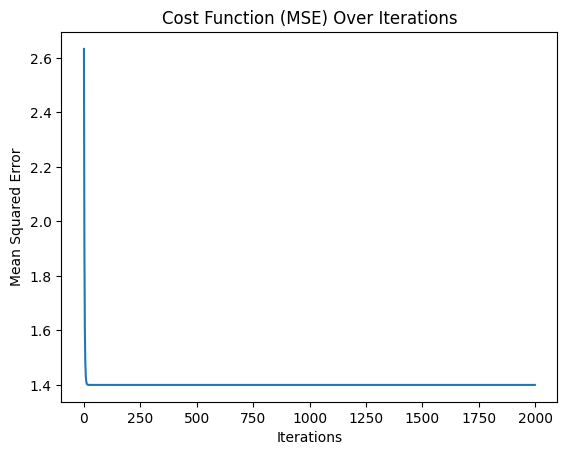

In [223]:
def mse(y_true, y_pred):
    return sum((y_true - y_pred)** 2)/len(y_true)

def rmse(y_true, y_pred):
    return np.sqrt(sum((y_true - y_pred)** 2)/len(y_true))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

coefficients = np.zeros(X_train_scaled.shape[1] + 1)
L = 0.1
epochs = 2000
n = float(len(X_train_scaled))
costs = []

print("Training multilinear regression...")
for epoch in range(epochs):
    y_pred = coefficients[0]
    for j in range(X_train_scaled.shape[1]):
        y_pred = y_pred + coefficients[j+1] * X_train_scaled[:, j]
    
    cost = (1/n) * sum((y_train - y_pred)**2)
    costs.append(cost)
    
    D_c0 = (-2/n) * sum(y_train - y_pred)
    coefficients[0] = coefficients[0] - L * D_c0
    
    for j in range(X_train_scaled.shape[1]):
        D_cj = (-2/n) * sum(X_train_scaled[:, j] * (y_train - y_pred))
        coefficients[j+1] = coefficients[j+1] - L * D_cj
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Cost (MSE) = {round(cost,4)}")

y_train_pred = coefficients[0]
for j in range(X_train_scaled.shape[1]):
    y_train_pred = y_train_pred + coefficients[j+1] * X_train_scaled[:, j]

y_test_pred = coefficients[0]
for j in range(X_test_scaled.shape[1]):
    y_test_pred = y_test_pred + coefficients[j+1] * X_test_scaled[:, j]

final_mse = mse(y_train, y_train_pred)
train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(f"\nFinal Results:")
print(f"Final MSE: {final_mse:.4f}")
print(f"Final RMSE: {train_rmse:.4f} ")
print(f"Verification: sqrt({final_mse:.4f}) = {np.sqrt(final_mse):.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

print(f"\nCoefficients:")
print(f"Intercept: {coefficients[0]:.4f}")
for i, coef in enumerate(coefficients[1:]):
    print(f"Feature {i+1}: {coef:.4f}")

plt.plot(costs)
plt.title('Cost Function (MSE) Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.show()

# Logistic Regression

## Binomial

In [224]:
df = pd.read_csv('Pistachio_Dataset.csv')
df = df.drop(columns = ['id'])
df.head()

,Area,Perimeter,Major_axis,Minor_axis,Eccentricity,Eqdiasq,Solidity,Covex_area,Extent,Aspect_Ratio,Roundness,Compactness,Shapefactor_1,Shapefactor_2,Shapefactor_3,Shapefactor_4,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio


In [225]:
df['Class'] = df['Class'].map({'Kirmizi_Pistachio':0, 'Siit_Pistachio':1})

In [226]:
df.isnull().sum()

Area             0
Perimeter        0
Major_axis       0
Minor_axis       0
Eccentricity     0
Eqdiasq          0
Solidity         0
Covex_area       0
Extent           0
Aspect_Ratio     0
Roundness        0
Compactness      0
Shapefactor_1    0
Shapefactor_2    0
Shapefactor_3    0
Shapefactor_4    0
Class            0
dtype: int64

In [227]:
X = df.drop(columns = ['Class'])
y = df['Class']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [229]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

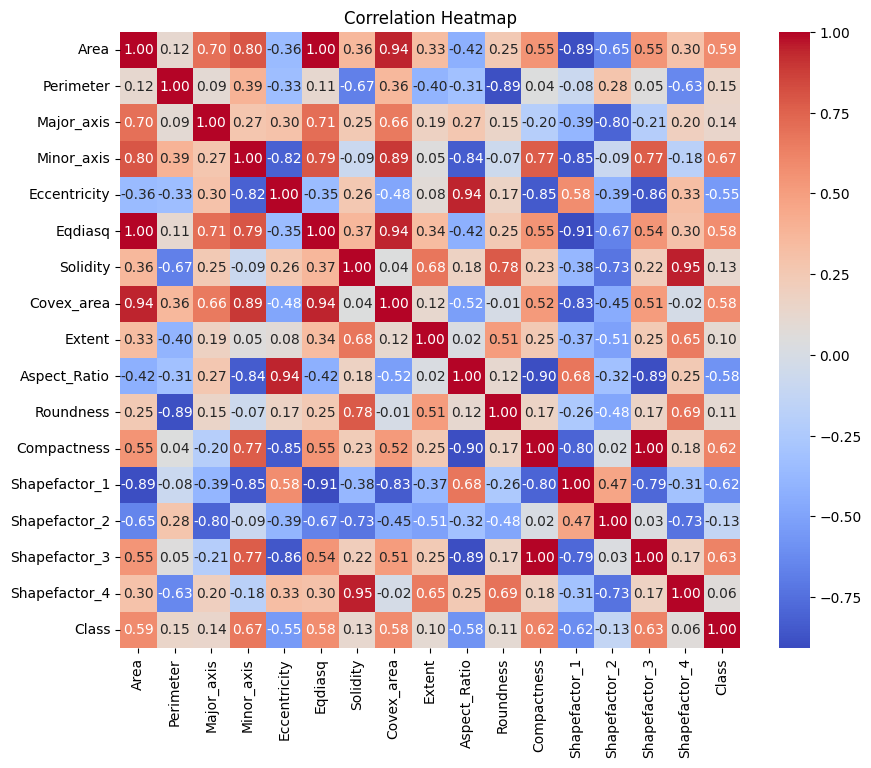

In [230]:
def heatmap_plot_multi(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
heatmap_plot_multi(df)

## Default

In [231]:
logisticReg = LogisticRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logisticReg.fit(X_tr, y_tr)
    val_predictions = logisticReg.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    if best_model is None or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = logisticReg
    print(f'Validation Accuracy: {val_accuracy}')
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.8633720930232558
Validation Accuracy: 0.9069767441860465
Validation Accuracy: 0.8866279069767442
Validation Accuracy: 0.8513119533527697
Validation Accuracy: 0.8483965014577259
Test Accuracy: 0.8604651162790697


In [232]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       244
           1       0.83      0.85      0.84       186

    accuracy                           0.86       430
   macro avg       0.86      0.86      0.86       430
weighted avg       0.86      0.86      0.86       430



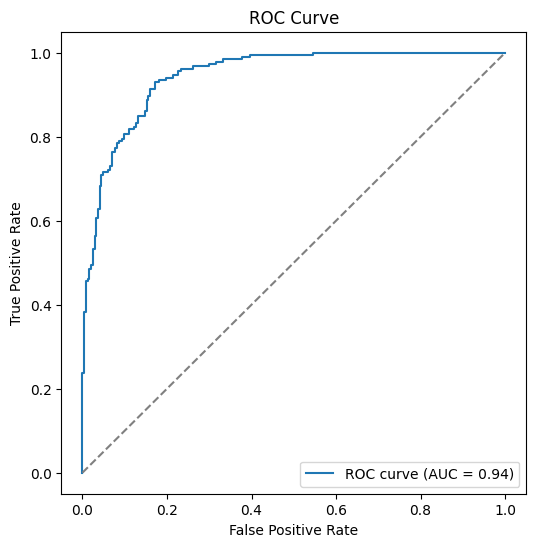

In [233]:
y_prob = best_model.predict_proba(X_test)[:, 1]   

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

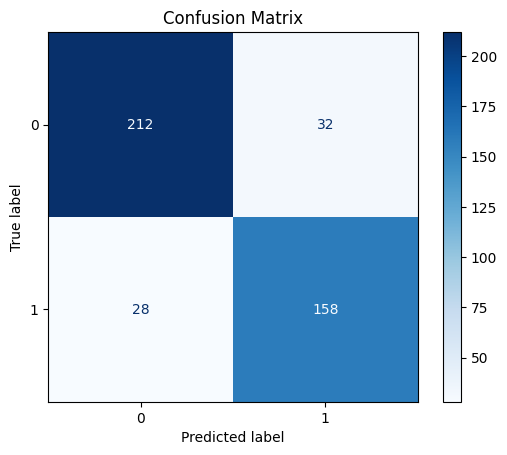

In [234]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Different itr

In [235]:
logisticReg = LogisticRegression(max_iter=3)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logisticReg.fit(X_tr, y_tr)
    val_predictions = logisticReg.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    if best_model is None or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = logisticReg
    print(f'Validation Accuracy: {val_accuracy}')
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.872093023255814
Validation Accuracy: 0.8924418604651163
Validation Accuracy: 0.872093023255814
Validation Accuracy: 0.8542274052478134
Validation Accuracy: 0.8571428571428571
Test Accuracy: 0.858139534883721


c:\Users\vihaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\vihaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## Ordinal

In [236]:
df = pd.read_csv('WineQT.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [237]:
df = df.drop(columns = ['Id'])
X = df.drop(columns = ['quality'])
y = df['quality']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

### Default

In [239]:
logisticReg = LogisticRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logisticReg.fit(X_tr, y_tr)
    val_predictions = logisticReg.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    if best_model is None or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = logisticReg
    print(f'Validation Accuracy: {val_accuracy}')
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')


Validation Accuracy: 0.5901639344262295
Validation Accuracy: 0.5737704918032787
Validation Accuracy: 0.5519125683060109
Validation Accuracy: 0.6174863387978142
Validation Accuracy: 0.6263736263736264
Test Accuracy: 0.62882096069869


In [240]:
logisticReg = LogisticRegression(solver='newton-cg')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logisticReg.fit(X_tr, y_tr)
    val_predictions = logisticReg.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    if best_model is None or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = logisticReg
    print(f'Validation Accuracy: {val_accuracy}')
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')


Validation Accuracy: 0.5901639344262295
Validation Accuracy: 0.5792349726775956
Validation Accuracy: 0.5519125683060109
Validation Accuracy: 0.6174863387978142
Validation Accuracy: 0.6263736263736264
Test Accuracy: 0.62882096069869


## Multibinomial

In [241]:
df = pd.read_csv('iris.csv')
df = df.drop(columns = ['Id'])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [242]:
le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])

In [243]:
X = df.drop(columns = ['Species'])
y = df['Species']

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [245]:
logisticReg = LogisticRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model = None
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logisticReg.fit(X_tr, y_tr)
    val_predictions = logisticReg.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    if best_model is None or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = logisticReg
    print(f'Validation Accuracy: {val_accuracy}')
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')


Validation Accuracy: 0.9583333333333334
Validation Accuracy: 0.9583333333333334
Validation Accuracy: 0.875
Validation Accuracy: 1.0
Validation Accuracy: 0.9166666666666666
Test Accuracy: 1.0
